# EllPHi ―Quick Start―

`EllPHi` is a light-weight Python library providing ellipse tangency solver and anisotropic ellipse persistent homology analysis tools.

In this notebook, we will show the basic usage of `EllPHi`.

In [1]:
import numpy
import matplotlib.pyplot as plt

import ellphi

In [2]:
%matplotlib inline

## Construct synthetic dataset

We construct and use the following synthetic dataset as an example.

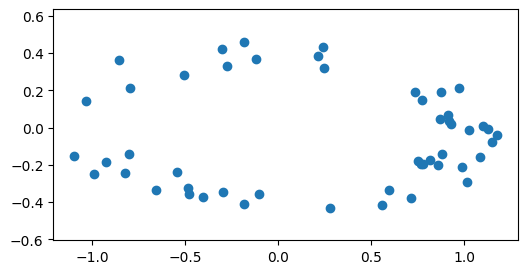

In [3]:
rng = numpy.random.default_rng(seed=7777)
num_points = 50
eps = 0.2
shrink_y = 0.4

theta = rng.uniform(0, 2 * numpy.pi, num_points)
noise = rng.uniform(-eps, eps, size=(2, num_points))
data = ellphi.unit_vector(theta) + noise
data[1] *= shrink_y

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(*data, marker='o')
ax.set_aspect('equal', adjustable='datalim')
plt.show()

## Mahalanobis distance associated with a covariance matrix $S$
In this section, we explain how ellipses are constructed from covariance matrices. If you are familiar with it, you may skip this section.

For a covariance matrix $S \in \mathbf{R}^{2 \times 2}$, we can define the Mahalanobis distance
$$ d_S^\mathrm{M}(x, x') = \sqrt{(x - x')^\top S^{-1} (x - x')}. $$
Note that $S$ is positive semi-definite. Then, the contour $d_S^\mathrm{M}(x, x_0) = r$ forms an ellipse centered at $x_0 \in \mathbf{R}^2$. The conic equation is
$$
(x - x_0)^\top S^{^1} (x - x_0) = r^2.
$$
Rescaling the equation and setting $A = \dfrac{1}{r^2} S^{-1}$, we obtain
$$
x^\top A x - 2 x^\top A x_0 + x_0^\top A x_0 = 1.
$$
Thus, setting $b = -A x_0$ and $c = x_0^\top A x_0$, the ellipse is represented by
$$
x^\top A x + 2 b^\top x + c = 1.
$$
<!--
By eigendecomposition of $S$, we get $S = U D U^\top$, where $U$ is an orthogonal matrix. The level set equation reads as
$$
(x - x_0)^\top U^\top D^{-1} U (x - x_0) = r^2.
$$
Thus, we obtain the level set equation of the norm form as
$$
\|D^{-1/2} U (x - x_0)\|^2 = r^2.
$$
The unit vector $\zeta = r^{-1} D^{-1/2} U (x - x_0)$ can be parametrized by $\zeta = (\cos t, \sin t)^\top$, from which we obtain the parametrization of the ellipse,
$$
x = x_0 + r U^\top D^{1/2} \zeta.
$$
-->

In [4]:
# compute mean and cov
mean = numpy.mean(data, axis=1)
cov = numpy.cov(data)
mean, cov

(array([ 0.23063179, -0.0502541 ]),
 array([[ 0.55210583, -0.00138233],
        [-0.00138233,  0.07153273]]))

In [5]:
# construct the quadric's coefficients
scale = 1.0
matrix_a = numpy.linalg.inv(cov) / scale**2
vector_b = -matrix_a @ mean
scalar_c = mean.T @ matrix_a @ mean
matrix_a, vector_b, scalar_c

(array([[ 1.81133459,  0.03500305],
        [ 0.03500305, 13.98029039]]),
 array([-0.41599229,  0.69449415]),
 np.float64(0.13084222949344526))

In [6]:
# prepare spatial variables x and y for visualization
num_grid = 200
x = numpy.linspace(-1.25, 1.25, num_grid)
y = numpy.linspace(-0.60, 0.60, num_grid)
xy = numpy.array(numpy.meshgrid(x, y)).transpose(1, 2, 0)[..., None]
matrix_a_ext = matrix_a[None, None, :, :]
vector_b_ext = vector_b[None, None, None, :]
xy.shape, matrix_a_ext.shape, vector_b_ext.shape

((200, 200, 2, 1), (1, 1, 2, 2), (1, 1, 1, 2))

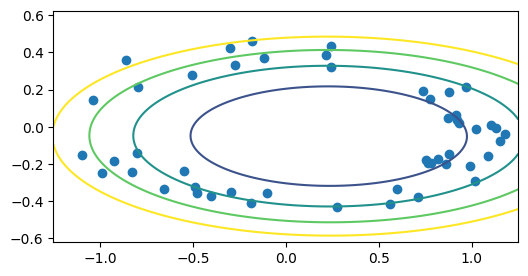

In [7]:
# the quadrics polynomial
z = xy.transpose(0, 1, 3, 2) @ matrix_a_ext @ xy
z += 2 * vector_b_ext @ xy
z += scalar_c

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(*data, marker='o')
ax.set_aspect('equal', adjustable='datalim')
plt.contour(x, y, z[..., 0, 0], levels=numpy.linspace(0, 4, 5))
plt.show()

`EllPhi` provides functions for these purposes of computation and visualization.

In [8]:
# compute the coefficients corresponding to matrix_a, vector_b, and scalar_c
ellphi.coef_from_cov([mean[0]], [mean[1]], cov)

array([[ 1.81133459,  0.03500305, 13.98029039, -0.41599229,  0.69449415,
         0.13084223]])

In [9]:
# confirm they coincide
matrix_a, vector_b, scalar_c

(array([[ 1.81133459,  0.03500305],
        [ 0.03500305, 13.98029039]]),
 array([-0.41599229,  0.69449415]),
 np.float64(0.13084222949344526))

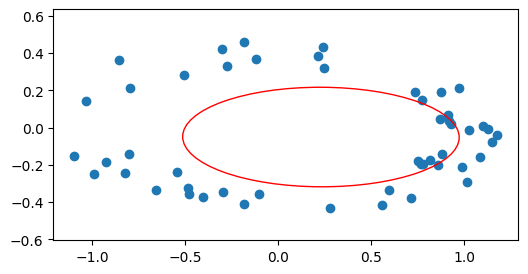

In [10]:
import ellphi.visualization
ellipse_obj = ellphi.visualization.ellipse_patch(*mean, cov=cov)
ellipse_obj.set(edgecolor='red')

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(*data, marker='o')
ax.add_patch(ellipse_obj)
ax.set_aspect('equal', adjustable='datalim')
plt.show()

## Ellipse Cloud Construction `ellphi.ellipse_cloud`

`EllPHi` provides a function `ellphi.ellipse_cloud` to construct all the local covariance ellipses for every $k$-neighbors.

In [11]:
ellcloud = ellphi.ellipse_cloud(data[0], data[1], k=5)
# ellcloud

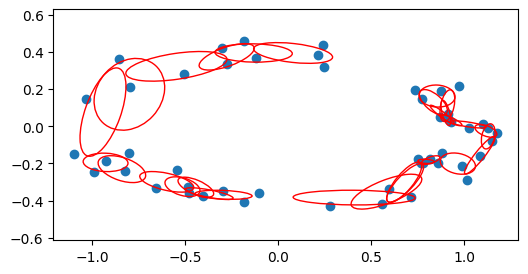

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(*data, marker='o')
ax.set_aspect('equal', adjustable='datalim')

for i in range(ellcloud.num_ellipses):
    mean, cov = ellcloud.means[i], ellcloud.covs[i]
    p = ellphi.visualization.ellipse_patch(*mean, cov=cov)
    p.set(edgecolor='red')
    ax.add_patch(p)
plt.show()

## Tangency solver `ellphi.tangency`

Suppose the ellipses' axes increase in proportion to time. The function `ellphi.tangency(ellipse1, ellipse2)` solves the tangency problem at which time the input ellipses first contact. The result `TangencyResult` contains the first time of tangency `t`, the `point` of tangency, and the associated Lagrange multiplier `mu` solving the minimization problem.

In [13]:
ellphi.tangency(ellcloud.coefs[0], ellcloud.coefs[1])

TangencyResult(t=0.2915172195956967, point=array([ 0.80708724, -0.18813744]), mu=0.6478788455206036)

## Constructing a quasi-distance matrix of pairwise tangencies

`EllPHi` also provides a function `ellphi.pdist_tangency` to compute all the tangency times for every pair of ellipses.

In [14]:
d = ellphi.pdist_tangency(ellcloud)
d.shape # num_ellipses * (num_ellipses - 1) / 2

(435,)

The resulting vector can be passed to `scipy.spatial.distance.squareform` to construct an $n \times n$ square symmetric matrix containing the tangency values. See also `scipy.spatial.distance.pdist`.  Note that the resulting **distance** matrix does not satisfy the triangle inequality in general, thus it forms a **quasi-metric** mathematically.

In [15]:
from scipy.spatial.distance import squareform
dist = squareform(d)
dist.shape

(30, 30)

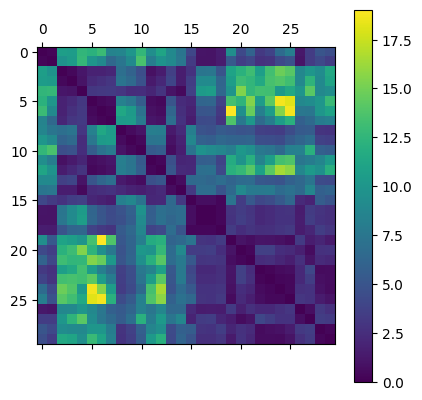

In [16]:
plt.matshow(dist)
plt.colorbar()
plt.show()

## Pipeline to any TDA library supporting VR filtrations

We can construct a Vietoris-Rips (VR) filtration from a quasi-distance matrix `dist`, and compute the persistent homology. The computation of VR filtrations is supported in most modern TDA libraries such as HomCloud, Gudhi, giotto-tda, ripser, and so on.

For example, we here use [HomCloud](https://homcloud.dev/) so that we can visualize the optimal 1-cycles (generators), the very useful inverse-analysis feature provided by HomCloud.

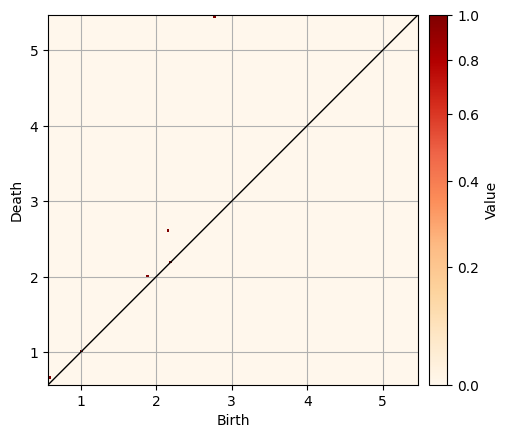

In [17]:
import homcloud.interface as hc

hc.PDList.from_rips_filtration(dist, maxdim=2, save_to="rips.pdgm", save_graph=True)
pdlist = hc.PDList("rips.pdgm")
pd1 = pdlist.dth_diagram(1)
pd1.histogram().plot(colorbar={"type": "loglog"})
plt.show()

In [18]:
bd = max(pd1.pairs(), key=lambda p: p.death_time())
optimal_1_cycle = bd.optimal_1_cycle()
bd, optimal_1_cycle.boundary_points()

(Pair(2.7583529949188232, 5.462862968444824), [29, 16, 15, 5, 14, 8])

Pair(2.7583529949188232, 5.462862968444824)


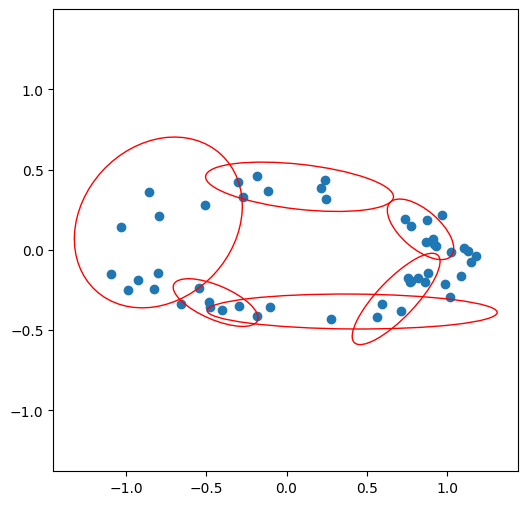

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(*data, marker='o')
ax.set_aspect('equal', adjustable='datalim')

for k in optimal_1_cycle.boundary_points():
    mean, cov = ellcloud.means[k], ellcloud.covs[k]
    p = ellphi.visualization.ellipse_patch(*mean, cov=cov, scale=bd.birth_time())
    p.set(edgecolor='red')
    ax.add_patch(p)

print(bd)
plt.show()